# BANA 320 Group Project - Three Gits
* **Problem Statement**: Does adding sentiment features from the first 90 days of reviews significantly improve the accuracy of predicting a restaurant’s 1-year Yelp rating, compared to using non-text features alone?

* **Target**: Overall Average Rating 12 months after first review

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import duckdb
from google.colab import auth
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy import stats

In [ ]:
# Authenticate Google profile
auth.authenticate_user()

To allow convenient use of the (very large) original datasets, we loaded the json files into Google Cloud Storage. We can access them directly, just like local files, using the paths listed below.

In [ ]:
# Raw datasets from Yelp
business_json = 'gs://raw-yelp-3892/yelp_academic_dataset_business.json'
checkin_json = 'gs://raw-yelp-3892/yelp_academic_dataset_checkin.json'
review_json = 'gs://raw-yelp-3892/yelp_academic_dataset_review.json'
tip_json = 'gs://raw-yelp-3892/yelp_academic_dataset_tip.json'
user_json = 'gs://raw-yelp-3892/yelp_academic_dataset_user.json'

## Initial Data Exploration & Cleaning

## Business Dataset:
Exploration of overall trends, before filtering by restaurants only.

In [ ]:
business_df = pd.read_json(business_json, lines=True)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
print(f"{business_df.shape[0]} total rows (businesses)")

150346 total rows (businesses)


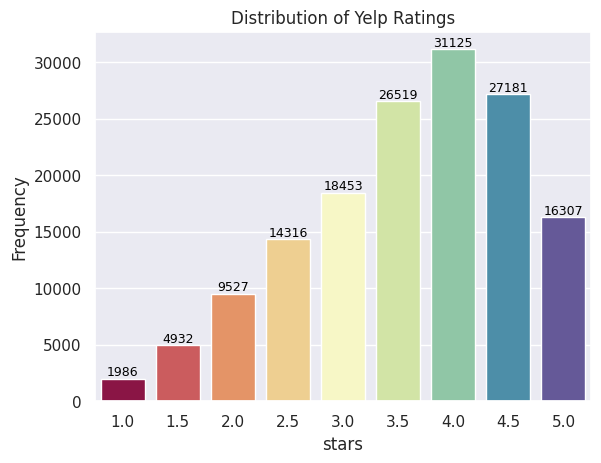

In [ ]:
# @title
# Visualize distribution of Yelp ratings
sns.set_theme()
ax = sns.countplot(data=business_df, x='stars', hue='stars', palette='Spectral', legend=False)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
      ax.text(p.get_x() + p.get_width() / 2,
              height,
              f'{int(height)}',
              ha='center',
              va='bottom',
              fontsize=9,
              color='black')
plt.title('Distribution of Yelp Ratings')
plt.ylabel('Frequency')
plt.show()

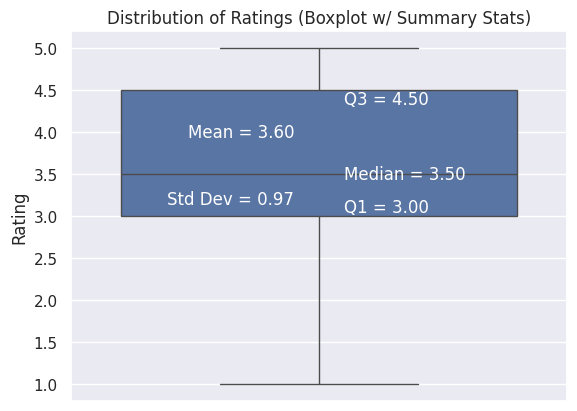

In [ ]:
# @title
# Compute quartiles
q1 = business_df['stars'].quantile(0.25)
median = business_df['stars'].quantile(0.5)
q3 = business_df['stars'].quantile(0.75)
iqr = q3 - q1
mean = business_df['stars'].mean()
std = business_df['stars'].std()

# Create boxplot
sns.boxplot(data=business_df, y='stars')
plt.ylabel('Rating')
plt.title('Distribution of Ratings (Boxplot w/ Summary Stats)')

# Add labels
plt.text(0.05, q1, f"Q1 = {q1:.2f}", va='bottom', color='white')
plt.text(0.05, median, f"Median = {median:.2f}", va='center', color='white')
plt.text(0.05, q3, f"Q3 = {q3:.2f}", ha='left', va='top', color='white')
plt.text(-0.05, 4, f"Mean = {mean:.2f}", ha='right', va='center', color='white')
plt.text(-0.05, 3.2, f"Std Dev = {std:.2f}", ha='right', va='center', color='white')

plt.show()

In [ ]:
business_df['review_count'].describe()

,review_count
count,150346.000000
mean,44.866561
std,121.120136
min,5.000000
25%,8.000000
50%,15.000000
75%,37.000000
max,7568.000000


Text(0.5, 1.0, 'Distribution of review_counts (Outliers Removed)')

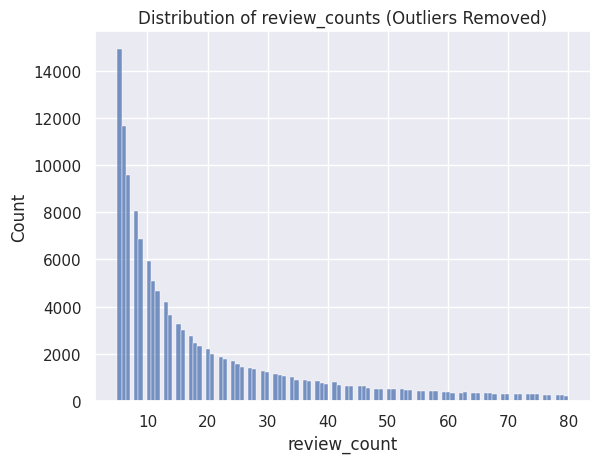

In [ ]:
# @title
# Remove review_count outliers for distribution visualization
q1 = business_df['review_count'].quantile(0.25)
median = business_df['review_count'].quantile(0.5)
q3 = business_df['review_count'].quantile(0.75)
iqr = q3 - q1
mean = business_df['review_count'].mean()
std = business_df['review_count'].std()
bus_review_counts = business_df[business_df['review_count'].between(q1-1.5*iqr, q3+1.5*iqr)]['review_count']
sns.histplot(bus_review_counts)
plt.title('Distribution of review_counts (Outliers Removed)')

## In-warehouse transformations achieved via dbt-BigQuery
https://github.com/vbalalian/three-gits
* filtered business dataset to only include restaurants
* filtered restaurant dataset to only include qualifying restaurants
  * min. 1 year of reviews
  * min. 3 reviews in the first 90 days
  * min. 10 reviews in the first year
* other datasets filtered by qualifying restaurants & time ranges
  * 12 month reviews dataset allows us to get our overall rating 12 months from first review
  * 90 day reviews dataset allows us to perform sentiment analysis of early reviews and create a sentiment_ratio feature
  * Aggregated restaurant checkin features
  * Aggregated restaurant zip code features


### Load the transformed tables
* aggregated (features & target) table
* 90 days review dataset (for sentiment analysis of `text`)

In [ ]:
# Set up DuckDB-BigQuery connection
duckdb.sql("""
INSTALL bigquery FROM community;
LOAD bigquery;
""")

In [ ]:
# Set up google cloud project in duckdb
duckdb.sql("""
ATTACH 'project=bana320-group-project' AS bq (TYPE bigquery, READ_ONLY);
""")

In [ ]:
# Load aggregated restaurants table (includes target and all features minus sentiment analysis)
agg_restaurants = duckdb.sql("""
select * from bq.dbt_yelp_data.agg_qualifying_restaurants
""").df().set_index('business_id').fillna(0)
agg_restaurants.head()

,name,address,city,state,postal_code,latitude,longitude,categories,first_review_date,first_90_review_count,...,users_avg_cool,users_avg_useful,users_avg_funny,users_avg_compliments,users_avg_years_elite,users_avg_num_friends,rating_diff_zip_avg_90,checkins_diff_zip_avg_90,reviews_diff_zip_avg_90,users_diff_zip_avg_90
business_id,,,,,,,,,,,,,,,,,,,,,
TjWKL-0U5AHZ7AQOsrP0Ew,Brio Italian Grille,901 Haddonfield Rd,Cherry Hill,NJ,08002,39.926525,-75.033376,"Nightlife, Italian, Restaurants, Gluten-Free, ...",2009-04-22 19:32:00,3,...,295.33,743.00,270.33,1.67,5.5,138.00,-1.39,0.00,-19.06,-18.42
xVLoxYL8Jrvj1JQlM_bfLw,Treesy's Soul Food Cafe,6 Shoppers Ln,Turnersville,NJ,08012,39.760448,-75.050771,"Cafes, Chicken Wings, Restaurants, Soul Food, ...",2015-07-04 00:32:19,3,...,1.00,4.00,0.33,0.00,0.0,22.00,0.89,-2.92,-6.83,-6.83
BqtxPTy5-b3gBBxGk-2nfg,Holy Tomato Pies,9 S Black Horse Pike,Gloucester Township,NJ,08012,39.801690,-75.066438,"Pizza, Restaurants, Food, Salad, Desserts",2013-06-22 14:58:37,3,...,22.00,63.33,11.67,0.00,3.0,17.33,0.89,5.08,-6.83,-6.83
kqRnm-AL4uoXNg4V15n10g,B-Unos,350 High St,Burlington,NJ,08016,40.078056,-74.858480,"Restaurants, Chicken Wings, Breakfast & Brunch...",2015-11-10 18:05:34,3,...,16111.67,20643.67,10667.33,0.00,9.0,629.67,0.47,-3.80,-7.70,-7.10
byIV7Y_5kTBk2H3qPzuDsw,Fratelli's Italian Restaurant,1414 Rt 130 N,Burlington,NJ,08016,40.087250,-74.827738,"Italian, Restaurants, Pizza",2015-01-24 00:36:26,3,...,17.67,50.00,9.67,0.00,2.0,127.67,0.47,2.20,-7.70,-7.10


In [ ]:
# Load 90 day reviews dataset
_90_day_reviews = duckdb.sql("""
select * from bq.dbt_yelp_data.fct_90_day_reviews
""").to_df()
_90_day_reviews.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,8NnKwxC71uLNWs00efgD7w,YhbCO1DVlNYkmVv8DCAIxw,---kPU91CF4Lq2-WlRu9Lw,5.0,2020-01-29 18:39:02,Unfortunately the site for Frankie's is incorr...,0,0,0
1,9j7uG9sA5WU7yraCQAqnGw,nRy6-tnPPeShNhZg9UiU4A,---kPU91CF4Lq2-WlRu9Lw,5.0,2020-02-11 00:30:51,Great new local seafood spot. It' actually rea...,0,0,0
2,3BTLIBMTYDl1moyujHHLNg,AKXWs8iaqLBTdU-slcvC_g,-0G_6-KFGpCpxTUlVXCMYQ,3.0,2014-01-19 18:41:38,Weird tacos for sure but they do taste good. T...,0,0,0
3,GS04AVFcyczDRRRzr8hgUA,WhDWiJqZpKNwiWJGHQs1XA,-0G_6-KFGpCpxTUlVXCMYQ,5.0,2014-01-17 01:39:14,Excellent food. I had the Gio Taco and citrus ...,0,0,0
4,yQ8TedKdzfbGQWaKX8jPYQ,fRrNc-QWQFL3iwXyUjpT2Q,-0G_6-KFGpCpxTUlVXCMYQ,4.0,2014-01-06 00:13:47,I've been to gios twice now. The atmosphere an...,0,0,1


In [ ]:
_90_day_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197715 entries, 0 to 197714
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    197715 non-null  object        
 1   user_id      197715 non-null  object        
 2   business_id  197715 non-null  object        
 3   stars        197715 non-null  float64       
 4   date         197715 non-null  datetime64[us]
 5   text         197715 non-null  object        
 6   useful       197715 non-null  int64         
 7   funny        197715 non-null  int64         
 8   cool         197715 non-null  int64         
dtypes: datetime64[us](1), float64(1), int64(3), object(4)
memory usage: 13.6+ MB


## Using VADER (Valence Aware Dictionary and sEntiment Reasoner), assign sentiment analysis scores to each review

In [ ]:
# Analyze sentiment of each review (takes a few minutes to run)
analyzer = SentimentIntensityAnalyzer()
reviews_90_sentiment = _90_day_reviews[['business_id', 'text']].copy()

sp_features = ['neg', 'neu', 'pos', 'compound']

scores = reviews_90_sentiment['text'].apply(analyzer.polarity_scores).apply(pd.Series)
reviews_90_sentiment[sp_features] = scores[sp_features]

reviews_90_sentiment.head()

,business_id,text,neg,neu,pos,compound
0,---kPU91CF4Lq2-WlRu9Lw,Unfortunately the site for Frankie's is incorr...,0.035,0.784,0.182,0.9594
1,---kPU91CF4Lq2-WlRu9Lw,Great new local seafood spot. It' actually rea...,0.000,0.470,0.530,0.9059
2,-0G_6-KFGpCpxTUlVXCMYQ,Weird tacos for sure but they do taste good. T...,0.100,0.786,0.114,0.4235
3,-0G_6-KFGpCpxTUlVXCMYQ,Excellent food. I had the Gio Taco and citrus ...,0.034,0.666,0.300,0.9943
4,-0G_6-KFGpCpxTUlVXCMYQ,I've been to gios twice now. The atmosphere an...,0.000,0.927,0.073,0.6249


In [ ]:
filter = sp_features + ['business_id']
agg_sentiment = reviews_90_sentiment[filter].groupby('business_id').mean()
agg_sentiment.head()

,neg,neu,pos,compound
business_id,,,,
---kPU91CF4Lq2-WlRu9Lw,0.008750,0.659500,0.332000,0.950925
-0G_6-KFGpCpxTUlVXCMYQ,0.035806,0.767790,0.196435,0.743832
-0TffRSXXIlBYVbb5AwfTg,0.021783,0.776217,0.201913,0.893730
-0__F9fnKt8uioCKztF5Ww,0.024200,0.825800,0.150200,0.702660
-1B9pP_CrRBJYPICE5WbRA,0.022549,0.762671,0.214768,0.943257


## Model Building: Phase 1 (non-sentiment features only)

In [ ]:
agg_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10957 entries, TjWKL-0U5AHZ7AQOsrP0Ew to iksVwRfpWymIUUFqw0tXpw
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   name                      10957 non-null  object        
 1   address                   10957 non-null  object        
 2   city                      10957 non-null  object        
 3   state                     10957 non-null  object        
 4   postal_code               10957 non-null  object        
 5   latitude                  10957 non-null  float64       
 6   longitude                 10957 non-null  float64       
 7   categories                10957 non-null  object        
 8   first_review_date         10957 non-null  datetime64[us]
 9   first_90_review_count     10957 non-null  int64         
 10  first_365_review_count    10957 non-null  int64         
 11  avg_rating_90             10957 non-null  float

In [ ]:
# Remove columns we won't be using
features_1 = [
    'first_90_review_count',
    'avg_rating_90',
    'sun_cnt', 'mon_cnt', 'tues_cnt', 'wed_cnt', 'thur_cnt', 'fri_cnt', 'sat_cnt',
    'morning_cnt', 'afternoon_cnt', 'evening_cnt', 'late_cnt',
    'users',
    'users_avg_reviews',
    'users_avg_avg_stars',
    'users_avg_fans',
    'users_avg_cool',
    'users_avg_useful',
    'users_avg_funny',
    'users_avg_compliments',
    'users_avg_years_elite',
    'users_avg_num_friends',
    'rating_diff_zip_avg_90',
    'checkins_diff_zip_avg_90',
    'reviews_diff_zip_avg_90',
    'users_diff_zip_avg_90'
    ]
target = 'avg_rating_365'

X = agg_restaurants[features_1].copy()
y = agg_restaurants[target].copy()

In [ ]:
# Normalize numerical features
scaler = StandardScaler()

X_nor = X.copy()
X_nor[features_1] = scaler.fit_transform(X)
X_nor.head()

,first_90_review_count,avg_rating_90,sun_cnt,mon_cnt,tues_cnt,wed_cnt,thur_cnt,fri_cnt,sat_cnt,morning_cnt,...,users_avg_cool,users_avg_useful,users_avg_funny,users_avg_compliments,users_avg_years_elite,users_avg_num_friends,rating_diff_zip_avg_90,checkins_diff_zip_avg_90,reviews_diff_zip_avg_90,users_diff_zip_avg_90
business_id,,,,,,,,,,,,,,,,,,,,,
TjWKL-0U5AHZ7AQOsrP0Ew,-0.806063,-2.334754,-0.580573,-0.536753,-0.541662,-0.586974,-0.605733,-0.610501,-0.617192,-0.287063,...,-0.029509,0.243937,0.166869,0.137278,0.443850,0.045814,-2.112842,-0.000009,-1.090514,-1.074986
xVLoxYL8Jrvj1JQlM_bfLw,-0.806063,1.446806,-0.580573,-0.536753,-0.541662,-0.586974,-0.117645,-0.217454,-0.617192,-0.287063,...,-0.392571,-0.460882,-0.367434,-0.123507,-1.617300,-0.598706,1.352866,-0.103374,-0.390785,-0.411903
BqtxPTy5-b3gBBxGk-2nfg,-0.806063,1.446806,-0.430148,-0.536753,0.774009,-0.071487,-0.605733,-0.217454,-0.345139,-0.287063,...,-0.366667,-0.404297,-0.344993,-0.123507,-0.493037,-0.624653,1.352866,0.179817,-0.390785,-0.411903
kqRnm-AL4uoXNg4V15n10g,-0.806063,0.497875,-0.580573,-0.265530,-0.278528,-0.586974,-0.605733,-0.610501,-0.617192,-0.092714,...,19.480235,19.224141,20.741483,-0.123507,1.755491,2.777632,0.714446,-0.134525,-0.440561,-0.427350
byIV7Y_5kTBk2H3qPzuDsw,-0.806063,0.497875,-0.279722,-0.265530,0.247741,-0.329231,-0.605733,-0.610501,-0.481166,-0.287063,...,-0.372008,-0.417010,-0.348951,-0.123507,-0.867791,-0.011582,0.714446,0.077868,-0.440561,-0.427350


In [ ]:
# Function to get mutual information of each feature with the target variable
def get_mutual_info_scores(X, y):
  mi = mutual_info_regression(X, y)
  mi_scores = pd.DataFrame({
      'column':X.columns.tolist(),
      'mutual_info':mi
      })
  return mi_scores.sort_values(by='mutual_info', ascending=False).reset_index(drop=True)

In [ ]:
mi_scores1 = get_mutual_info_scores(X_nor, y)
mi_scores1

,column,mutual_info
0,avg_rating_90,0.756904
1,rating_diff_zip_avg_90,0.520133
2,users_avg_avg_stars,0.245166
3,users,0.061565
4,first_90_review_count,0.058211
5,sun_cnt,0.051870
6,evening_cnt,0.047210
7,checkins_diff_zip_avg_90,0.043655
8,fri_cnt,0.036613
9,wed_cnt,0.031165


As expected, the number one predictor of 1 year average rating is... 90 day average rating. For this analysis, we'll remove features with a mutual info score < 0.04.

In [ ]:
# Filter by features above mutual info threshhold
selected_features = mi_scores1[mi_scores1['mutual_info'] >= 0.04]['column'].tolist()
X_nor_sel = X_nor[selected_features].copy()

<Axes: xlabel='avg_rating_90', ylabel='avg_rating_365'>

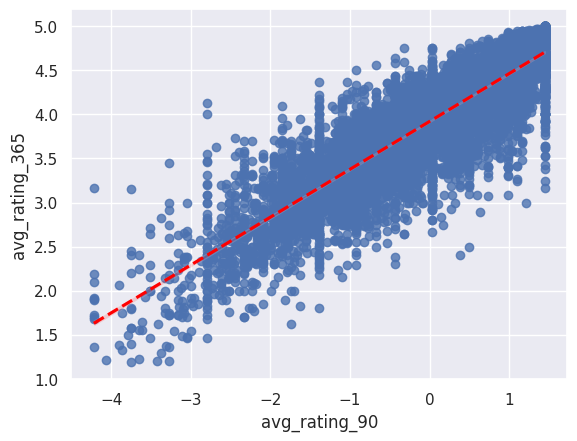

In [ ]:
# avg_rating_90 has a clear linear relationship with the target
sns.regplot(x=X_nor_sel['avg_rating_90'], y=y, line_kws={'color':'red', 'linestyle':'--'})

<Axes: xlabel='rating_diff_zip_avg_90', ylabel='avg_rating_365'>

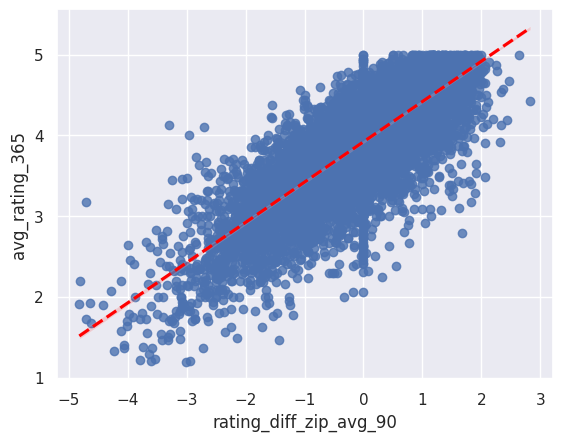

In [ ]:
# The next highest mutual info feature also has a clear linear relationship with the target
sns.regplot(x=X_nor_sel['rating_diff_zip_avg_90'], y=y, line_kws={'color':'red', 'linestyle':'--'})

<Axes: xlabel='users_avg_avg_stars', ylabel='avg_rating_365'>

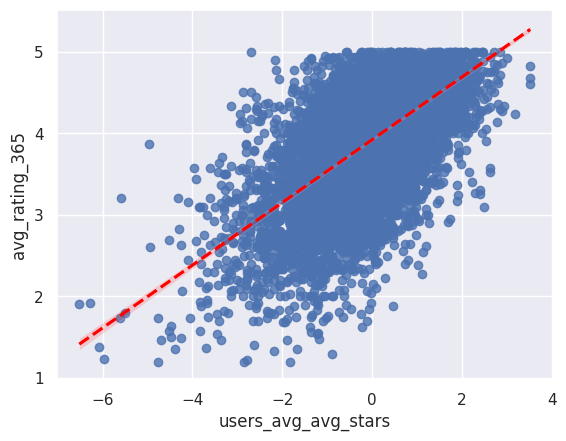

In [ ]:
# The third highest mutual info feature has a less linear relationship with the target
sns.regplot(x=X_nor_sel['users_avg_avg_stars'], y=y, line_kws={'color':'red', 'linestyle':'--'})

In [ ]:
# Function for scoring models
def get_cv_score(X, y, model):

    my_model = model

    scores = -1 * cross_val_score(my_model, X, y, cv=5, scoring='neg_mean_squared_error')

    return scores.mean()

In [ ]:
# The models we'll be using
models = {
    'SVR':SVR(kernel='linear'),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor(random_state=24),
    'XGBRegressor':XGBRegressor(random_state=24)
}

In [ ]:
# Cross-validation (mean squared error) scores for each model
model_cv_scores1 = pd.DataFrame(
    {'model': [model for model in models],
     'score': [get_cv_score(X=X_nor_sel, y=y, model=models[model]) for model in models]}
)
model_cv_scores1.sort_values(by='score')

,model,score
1,LinearRegression,0.094420
0,SVR,0.094644
2,RandomForestRegressor,0.098906
3,XGBRegressor,0.105301


In [ ]:
# Function to combine multiple model prediction sets
def combined_predictions(X_train, X_test, y_train, models:dict):

  predictions = {}

  for model in models:
    my_model = models[model]
    my_model.fit(X_train, y_train)
    predictions[model] = my_model.predict(X_test)

  combined_df = pd.DataFrame(predictions, index=X_test.index)
  return combined_df

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_nor_sel, y, random_state=24)

In [ ]:
# Get predictions from each model, and get their combined average
predictions1 = combined_predictions(X_train, X_test, y_train, models)
predictions1['Stacked'] = predictions1.mean(axis=1)
predictions1.head()

,SVR,LinearRegression,RandomForestRegressor,XGBRegressor,Stacked
business_id,,,,,
pJD9h8b6VesW5zpWB7sowQ,4.499881,4.455860,4.4587,4.545756,4.490049
jZq8xsKyCrRRzJenCKKn-Q,4.172702,4.136460,4.1587,4.102457,4.142580
cBp1fn2LXpSHe4VbTXLYEw,4.371052,4.351249,4.3055,4.326905,4.338677
AnGMeNzwSdJHxuHdwPxanA,4.301972,4.262028,4.2135,4.202358,4.244965
4Vn3QrrIAWoH4fL5s6kqdA,3.129812,3.130615,3.5970,3.753116,3.402636


In [ ]:
preds_vs_actual1 = predictions1.copy()
preds_vs_actual1['Actual'] = y_test
preds_vs_actual1.head()

,SVR,LinearRegression,RandomForestRegressor,XGBRegressor,Stacked,Actual
business_id,,,,,,
pJD9h8b6VesW5zpWB7sowQ,4.499881,4.455860,4.4587,4.545756,4.490049,4.59
jZq8xsKyCrRRzJenCKKn-Q,4.172702,4.136460,4.1587,4.102457,4.142580,4.64
cBp1fn2LXpSHe4VbTXLYEw,4.371052,4.351249,4.3055,4.326905,4.338677,4.52
AnGMeNzwSdJHxuHdwPxanA,4.301972,4.262028,4.2135,4.202358,4.244965,4.37
4Vn3QrrIAWoH4fL5s6kqdA,3.129812,3.130615,3.5970,3.753116,3.402636,2.90


### Phase 2: Add sentiment features

In [ ]:
X_nor_sel2 = X_nor_sel.copy()
X_nor_sel2[sp_features] = agg_sentiment[sp_features]

In [ ]:
get_mutual_info_scores(X_nor_sel2, y)

,column,mutual_info
0,avg_rating_90,0.762774
1,rating_diff_zip_avg_90,0.516223
2,pos,0.295627
3,neg,0.250505
4,users_avg_avg_stars,0.246079
5,compound,0.241532
6,neu,0.158934
7,first_90_review_count,0.070643
8,users,0.067170
9,sun_cnt,0.040574


This already looks promising. Our new sentiment features rank among the top in terms of mutual information.

In [ ]:
# Cross-validation (mean squared error) scores for each model
model_cv_scores2 = pd.DataFrame(
    {'model': [model for model in models],
     'score': [get_cv_score(X=X_nor_sel2, y=y, model=models[model]) for model in models]}
)
model_cv_scores2.sort_values(by='score')

,model,score
1,LinearRegression,0.094273
0,SVR,0.094563
2,RandomForestRegressor,0.095548
3,XGBRegressor,0.104105


In [ ]:
# Phase 2 train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_nor_sel2, y, random_state=24)

In [ ]:
# Get predictions from each model, and get their combined average
predictions2 = combined_predictions(X_train2, X_test2, y_train2, models)
predictions2['Stacked'] = predictions2.mean(axis=1)

In [ ]:
preds_vs_actual2 = predictions2.copy()
preds_vs_actual2['Actual'] = y_test2
preds_vs_actual2.head()

,SVR,LinearRegression,RandomForestRegressor,XGBRegressor,Stacked,Actual
business_id,,,,,,
pJD9h8b6VesW5zpWB7sowQ,4.493578,4.448891,4.4465,4.507961,4.474233,4.59
jZq8xsKyCrRRzJenCKKn-Q,4.186699,4.149866,4.0667,4.061705,4.116243,4.64
cBp1fn2LXpSHe4VbTXLYEw,4.372823,4.353286,4.3100,4.429827,4.366484,4.52
AnGMeNzwSdJHxuHdwPxanA,4.308685,4.266872,4.2632,4.219493,4.264563,4.37
4Vn3QrrIAWoH4fL5s6kqdA,3.173707,3.177720,3.4223,3.328490,3.275554,2.90


In [ ]:

# Calculate residuals (errors) for each model
residuals_phase1 = {}
residuals_phase2 = {}

for model in ['SVR', 'LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'Stacked']:
    residuals_phase1[model] = np.abs(predictions1[model] - y_test)
    residuals_phase2[model] = np.abs(predictions2[model] - y_test2)

# Perform paired t-test for each model
print("=" * 70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 70)
print("\nH0: Adding sentiment features does NOT improve prediction accuracy")
print("H1: Adding sentiment features DOES improve prediction accuracy")
print("\nPaired t-test results (comparing absolute errors):\n")

t_test_results = []

for model in ['SVR', 'LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'Stacked']:
    # Paired t-test (one-tailed, testing if phase1 errors > phase2 errors)
    t_stat, p_value = stats.ttest_rel(residuals_phase1[model], residuals_phase2[model])

    # One-tailed p-value
    p_value_one_tailed = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)

    mean_error_phase1 = residuals_phase1[model].mean()
    mean_error_phase2 = residuals_phase2[model].mean()
    error_reduction = mean_error_phase1 - mean_error_phase2
    pct_improvement = (error_reduction / mean_error_phase1) * 100

    t_test_results.append({
        'Model': model,
        'Phase1_MAE': mean_error_phase1,
        'Phase2_MAE': mean_error_phase2,
        'Error_Reduction': error_reduction,
        'Pct_Improvement': pct_improvement,
        't_statistic': t_stat,
        'p_value': p_value_one_tailed,
        'Significant': 'Yes' if p_value_one_tailed < 0.05 else 'No'
    })

    print(f"{model}:")
    print(f"  Mean Absolute Error (Phase 1): {mean_error_phase1:.4f}")
    print(f"  Mean Absolute Error (Phase 2): {mean_error_phase2:.4f}")
    print(f"  Error Reduction: {error_reduction:.4f} ({pct_improvement:.2f}% improvement)")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value (one-tailed): {p_value_one_tailed:.4f}")
    print(f"  Significant at α=0.05? {t_test_results[-1]['Significant']}")
    print()

# Create summary DataFrame
t_test_df = pd.DataFrame(t_test_results)
print("\nSummary Table:")
print(t_test_df.to_string(index=False))

STATISTICAL SIGNIFICANCE TESTING

H0: Adding sentiment features does NOT improve prediction accuracy
H1: Adding sentiment features DOES improve prediction accuracy

Paired t-test results (comparing absolute errors):

SVR:
  Mean Absolute Error (Phase 1): 0.2212
  Mean Absolute Error (Phase 2): 0.2210
  Error Reduction: 0.0002 (0.09% improvement)
  t-statistic: 0.8773
  p-value (one-tailed): 0.1902
  Significant at α=0.05? No

LinearRegression:
  Mean Absolute Error (Phase 1): 0.2224
  Mean Absolute Error (Phase 2): 0.2222
  Error Reduction: 0.0002 (0.10% improvement)
  t-statistic: 0.9400
  p-value (one-tailed): 0.1737
  Significant at α=0.05? No

RandomForestRegressor:
  Mean Absolute Error (Phase 1): 0.2274
  Mean Absolute Error (Phase 2): 0.2259
  Error Reduction: 0.0016 (0.69% improvement)
  t-statistic: 0.9369
  p-value (one-tailed): 0.1744
  Significant at α=0.05? No

XGBRegressor:
  Mean Absolute Error (Phase 1): 0.2348
  Mean Absolute Error (Phase 2): 0.2357
  Error Reduction: 

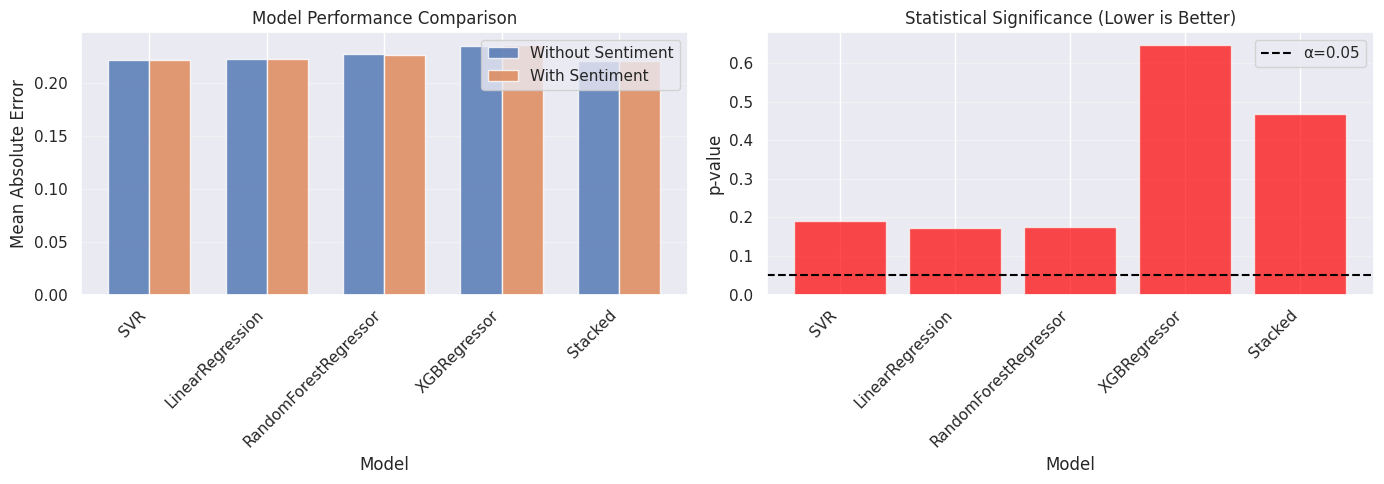

In [ ]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error comparison
models_list = t_test_df['Model'].tolist()
x_pos = np.arange(len(models_list))
width = 0.35

axes[0].bar(x_pos - width/2, t_test_df['Phase1_MAE'], width, label='Without Sentiment', alpha=0.8)
axes[0].bar(x_pos + width/2, t_test_df['Phase2_MAE'], width, label='With Sentiment', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_list, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: P-values
colors = ['green' if p < 0.05 else 'red' for p in t_test_df['p_value']]
axes[1].bar(x_pos, t_test_df['p_value'], color=colors, alpha=0.7)
axes[1].axhline(y=0.05, color='black', linestyle='--', label='α=0.05')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('p-value')
axes[1].set_title('Statistical Significance (Lower is Better)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_list, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Final conclusion
significant_count = sum(t_test_df['Significant'] == 'Yes')
print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
if significant_count >= 3:
    print(f"✓ {significant_count} out of {len(models_list)} models show statistically significant")
    print("  improvement when sentiment features are added (p < 0.05).")
    print("\n→ We can conclude that sentiment features from the first 90 days")
    print("  significantly improve prediction accuracy for 1-year Yelp ratings.")
else:
    print(f"X {significant_count} out of {len(models_list)} models show statistically")
    print("  significant improvement (p < 0.05).")
    print("\n→ Evidence is insufficient to conclude that sentiment features")
    print("  significantly improve prediction accuracy.")


CONCLUSION
✗ 0 out of 5 models show statistically
  significant improvement (p < 0.05).

→ Evidence is insufficient to conclude that sentiment features
  significantly improve prediction accuracy.
